### Import opencl modules

In [1]:
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
import os

### Setup params for all runs

In [2]:
current_risk_beta = 0.0165

# NB: OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=1.0 * current_risk_beta,
    primary_school=1.0 * current_risk_beta,
    secondary_school=1.0 * current_risk_beta,
    home=1.0 * current_risk_beta,
    work=0.0 * current_risk_beta,
)

individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=1.0,
    asymptomatic=0.75,
    symptomatic=1.0
)

proportion_asymptomatic = 0.4

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [3]:
opencl_dir = "./opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

### Run OpenCL simulation for multiple repetitions

In [12]:
iterations = 100
repetitions = 4
summaries = []
num_seed_days = 10
use_gpu=False

for i in range(repetitions):
    # load snapshot
    snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
    
    # set params
    snapshot.update_params(params)
    
    # set the random seed of the model for each repetition, otherwise it is completely deterministic
    snapshot.seed_prngs(i)

    # seed initial infections using GAM initial cases
    data_dir = os.path.join(opencl_dir, "data")
    snapshot.seed_initial_infections(num_seed_days=num_seed_days, data_dir=data_dir)

    # Create a simulator and upload the snapshot data to the OpenCL device
    kernel_dir = os.path.join(opencl_dir, "ramp", "kernels")
    simulator = Simulator(snapshot, kernel_dir=kernel_dir, gpu=use_gpu)
    simulator.upload_all(snapshot.buffers)
    
    print(f"Running simulation {i+1} out of {repetitions}")
    summary, final_state = run_headless(simulator, snapshot, iterations, quiet=True)
    summaries.append(summary)
    print("Final counts:")
    summary.print_counts(iterations-1)

/home/rory/miniconda3/envs/ramp-ua/lib/python3.7/site-packages/pyopencl/__init__.py:254: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Running simulation 1 out of 4


Running simulation: 100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


Final counts:
	Susceptible: 622497
	Exposed: 936
	Presymptomatic: 818
	Asymptomatic: 3005
	Symptomatic: 4653
	Recovered: 63171
	Dead: 229


/home/rory/miniconda3/envs/ramp-ua/lib/python3.7/site-packages/pyopencl/__init__.py:254: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Running simulation 2 out of 4


Running simulation: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Final counts:
	Susceptible: 618911
	Exposed: 694
	Presymptomatic: 643
	Asymptomatic: 2260
	Symptomatic: 3553
	Recovered: 68979
	Dead: 269


/home/rory/miniconda3/envs/ramp-ua/lib/python3.7/site-packages/pyopencl/__init__.py:254: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Running simulation 3 out of 4


Running simulation: 100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


Final counts:
	Susceptible: 620636
	Exposed: 809
	Presymptomatic: 676
	Asymptomatic: 2550
	Symptomatic: 3970
	Recovered: 66387
	Dead: 281


/home/rory/miniconda3/envs/ramp-ua/lib/python3.7/site-packages/pyopencl/__init__.py:254: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Running simulation 4 out of 4


Running simulation: 100%|██████████| 100/100 [00:12<00:00,  8.05it/s]

Final counts:
	Susceptible: 620200
	Exposed: 817
	Presymptomatic: 717
	Asymptomatic: 2623
	Symptomatic: 3885
	Recovered: 66787
	Dead: 280


### Plot output summary data

In [13]:
import matplotlib.pyplot as plt
from microsim.opencl.ramp.disease_statuses import DiseaseStatus


def plot_summary_counts(summary, repetition_num):
    x = range(iterations)
    
    for disease_status in DiseaseStatus:
        plt.plot(x, summary.total_counts[disease_status.value], label=disease_status.name)
    
    plt.title(f"Results - repetition {repetition_num}")
    plt.legend() 
    plt.show()
    

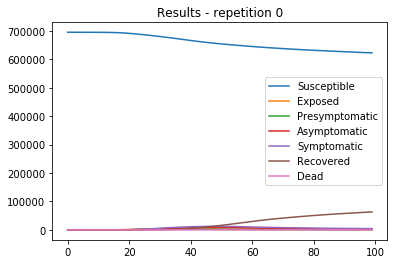

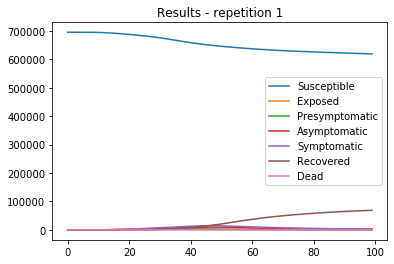

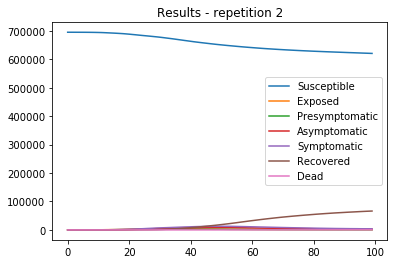

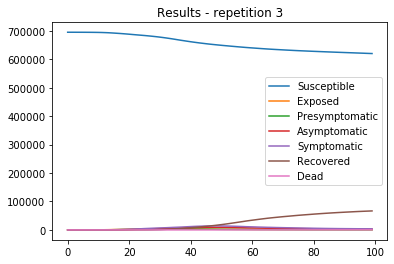

In [14]:
for i, summary in enumerate(summaries):
    plot_summary_counts(summary, i)

### Plot disease statuses by age

In [7]:
def plot_disease_status_by_age(summary, disease_status):
    age_thresholds = summary.age_thresholds
    age_counts = summary.age_counts[disease_status]
    x = range(iterations)
    
    lower_age_bound = 0
    for (i, age_threshold) in enumerate(age_thresholds):
        plt.plot(x, age_counts[i], label=f"{lower_age_bound} - {age_threshold}")
        lower_age_bound = age_threshold
    
    plt.title(f"Num {disease_status} people by age group")
    plt.legend() 
    plt.show()
    

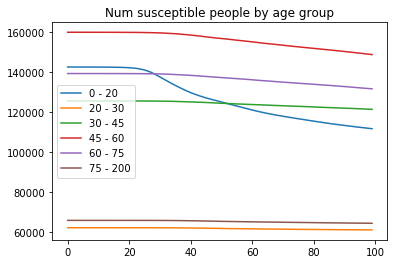

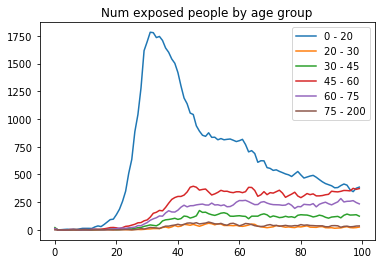

In [8]:
plot_disease_status_by_age(summaries[0], "susceptible")
plot_disease_status_by_age(summaries[0], "exposed")

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


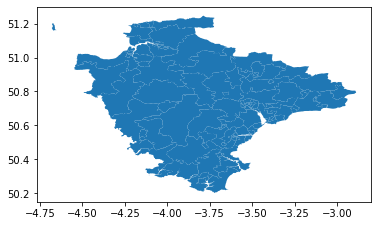

In [9]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [10]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

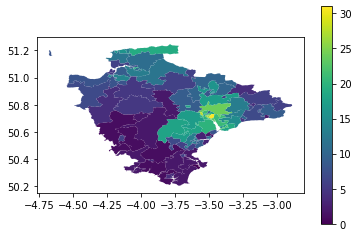

In [11]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)